In [2]:
# Importar librerías

import pandas as pd
import matplotlib as mlt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PyQt5 # si se trabaja en local, para que #matplolib qt corra

In [3]:
# Para que las gráficas se impriman no en el notebook, sino en una nueva pestaña
%matplotlib qt

# Crear la Matrix y dar realidad física a la simulación

In [4]:
# Coordenadas de mundo
nm = 1e-9
um = 1e-6
mm = 1e-3
cm = 1e-2

# Longitud de onda
w_length = 650*nm


# # Solo por operación definimos N y M de una imagen 2048 x 2048
# N = 2048 # coordenada X
# M = 2048 # coordenada Y


# Diferenciales, como N y M pendientes por definir para una imagen
dx = dy = 1*um # los diferenciales (tamaño de pixel)

# Definamos algunas funciones de interés

In [5]:
# Función para graficar complejos
def fun_ploteo_complejo(mat, indicador, escala, mapa_color = 'gray'):
    """
    mat  es una matriz compleja a plotear
    indicador = I para intensidad, A para amplitud, P para fase
    escala = 1 para nada, 0 para logarítmica
    """

    if(indicador =="I"):
        mat = np.abs(mat)**2
    elif(indicador == "A"):
        mat = np.abs(mat)
    elif(indicador == "P"):
        mat = np.angle(mat)

    if (escala == 1):
        plt.figure()
        plt.imshow(mat, cmap = mapa_color)
        plt.colorbar()
        plt.show()
    else:    
        plt.figure()
        plt.imshow( np.log( mat + 0.000000001), cmap = mapa_color)
        plt.colorbar()
        plt.show()

#----------------------------------------------------------------------------------------------------------------
# Función que convierte campos de 3 canales a un solo canal 
def fun_monocromador(campo_colorado, canal = 0):
    '''
    fun_monocromador es una función que extrae los datos de un solo canal de un campo, se puede entender
    como si un campo se compone de diferentes frecuencias, seleccionar solo los valores de esa frecuencia en 
    en particular que conforman el campo. 
    
    Esta función acepta solo campos con más de un solo canal, si mete de 1 canal, saldrán datos incorrectos

    Variables de entrada
     - campo_colorado: (numpy.ndarray) ; es el campo al cual se filtrará solo los componentes de una frecuencia que
                                         lo consituyen, tiene dimensiones L_x,L_y,canales
     - canal: (int) ; es el índice de los datos correspondientes a la frecuencia que se desea seleccionar  
                      por ejemplo una imagen RGB tiene las frecuencias de rojo en canal = 0, verde en canal = 1,
                      y azul en canal = 2.
                      Por defecto se escoge el canal 0     
                                                  
    '''

    campo_monocromático = campo_colorado[:,:,canal] #Tomar todas las filas y columnas, pero solo los valores del canal
                                                    # de interés

    return (campo_monocromático)

#----------------------------------------------------------------------------------------------------------------
# Función para "Pading"
def fun_pad(campo):
    '''
    fun_pad es una función que "padea" un campo (imagen) 2D con ceros tal que duplica su longitud y altura

    Solo recibe imágenes de 1 canal

    Variables de entrada:
     - campo: (numpy.ndarray) ; es el campo a padear de L_x y L_y dimensiones físicas reales

    Variables de salida:
     - campo_paded: (numpy.ndarray) ; es el campo padeado con ceros de dimensiones 2*L_x y 2*L_y 
    '''
    # extraer las dimensiones del pad
    dimension_pad = np.array( [np.shape(campo)[0] , np.shape(campo)[1] ] ) / 2

    # padear el campo con ceros
    campo_paded = np.pad(campo, ( (int(dimension_pad[0]), int(dimension_pad[0]) ), (int(dimension_pad[1]), int(dimension_pad[1])) ), mode = 'constant', constant_values = (0,0) )

    return (campo_paded)

#----------------------------------------------------------------------------------------------------------------
# Función extractora de características de un campo (imagen) 2D

# Nota: Función por depurar y mejorar,, no está terminada, saltarla
def fun_extractor(campo, L_x, L_y, dx, dy):
    '''
    fun_extractor es una función que extrae las características de interés de un campo (imagen) 2D
    que puede ser de 1 o  3 canales de tamaño con dimensiones físicas reales L_x * L_y que fue medida
    con pixeles de tamaño dx,dy 

    Variables de entrada:
    - campo: (numpy.ndarray) ; Es la imagen que vamos a difractar
    - L_x: (int) ; Dimension x del campo
    - L_y: (int) ; Dimension y del campo
    - dx: (int) ; Dimension x del pixel
    - dy: (int) ; Dimension y del pixel

    Variables de salida:
    - campo_data: (numpy.ndarray) ; Arreglo 2x2, su primer elemento tiene el número de muestras en x y en y
                                  el segundo tiene los deltas en x y en y.

    '''
    # Tamaño de la muestra
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)


    campo_data =np.array( [N_x, N_y] )

    return(campo_data)


#----------------------------------------------------------------------------------------------------------------
# Función calculadora del z crítico
def fun_z_c(M, dx, w_length):
    '''
    fun_z_c es una función que calcula el la distancia de propagación crítica (z crítico) donde los métodos
    de propagación AS y Fresnel funcionan, dados un campo, tamaño de discretización y longitu de onda
    
    Variables de entrada
     - M: int ; número de muestreos
     - dx: float ; tamaño de discretización (tamaño del pixel)
     - w_lenght: float ; longitud de onda

    Variables de salida
     - z_c: float ; z crítico
    '''
    z_c = M*dx**2/w_length

    return z_c
#----------------------------------------------------------------------------------------------------------------
# Función para crear máscaras cuadradas y circulares centradas en la imagen
def fun_mask(dim, L_R, tipo = 1, forma ='circ'):
    '''
    fun_mask es una función que crea y grafica máscaras ciruclares o cuadradas centradas en la imagen
    Variables de entrada
     - dim: int ; dimensión del campo
     - L_R: int ; tamaño de la máscara (radio o longitud)
     - tipo: int ; 0 para un obstaculo
                 ; 1 para una apertura
     - forma: str ; 'cir' para circulos
                    'rect' para cuadrados

    Variables de salida
     - mascara: matriz de dimensiones  dim x dim con una mascara 
    '''

    if tipo == 0:
        mascara = np.ones(np.array([dim,dim]), dtype = "uint8") # uint8 tipo de la variable de la matriz (enteros de 8 bit)
    else:
        mascara = np.zeros(np.array([dim,dim]), dtype = "uint8") # uint8 tipo de la variable de la matriz (enteros de 8 bit)

    # Como mi imagen no es cuadrada, entonces necesito dos coordenadas
    # para el centro
    centro1 = int(mascara.shape[0]/2)
    centro2 = int(mascara.shape[1]/2)

    if forma == 'circ':
        #Graficar la máscara circular 
        cv2.circle(mascara, (centro1, centro2), L_R, tipo, -1)
        plt.figure()
        plt.imshow(mascara)
        plt.colorbar() # Para mostrar barra de colores
        plt.show()

    elif forma == 'rect':
        inicio = (int(centro1-L_R/2),int(centro2-L_R/2))
        fin = (int(centro1+L_R/2),int(centro2+L_R/2))
        cv2.rectangle(mascara, inicio, fin,  tipo, -1)
        plt.figure()
        plt.imshow(mascara)
        plt.colorbar() # Para mostrar barra de colores
        plt.show()
    
    return mascara

#----------------------------------------------------------------------------------------------------------------

   # Función del kernel de una transformada discreta de Fourier y su inversa exp(+-(1j/(2pi))*(n*p/N_x + m*q*N_y))
def fun_fourker( cont_n_m, cont_p_q, N_array, ift = False ):
    '''
    Función  fun_fourker: es una función que calcula la exponencial exp(+-(1j/(2pi*N))*(p*n + q*m)) siendo el signo
    + para la transformada invera y - para la transformada normal
     
    Nota: 1j lo utilizamos para representar el complejo i

    Variables de entrada:
    - cont_n_m: (np.ndarray 1x2) ; arreglo que contiene los contadores n y m del espacio real (x,y)
    - cont_p_q: (np.ndarray 1x2) ; arreglo que contiene los contadores p y q del espacio recíprocro (fx,fy)
    - N_array: (np.ndarray 1x2) ; arreglo que contiene el número de las muestras N_x en x y N_y en y
    - ift: (bool) ; indica si se está calculando transformada o su inversa, por defecto es False
        
    Variables de salida:
    - fourker: (complex) ; valor exponencial evaluada con las variables de entrada

    '''
        #descomprimir
    n = cont_n_m[0]
    m = cont_n_m[1]

    p = cont_p_q[0]
    q = cont_p_q[1]

    N_x = N_array[0]
    N_y = N_array[1]

        
    if(ift == False):
        fourker = np.exp(-(2j*np.pi * (n*p/N_x + m*q/N_y) ) )
    else:
        fourker = np.exp( (2j*np.pi * (n*p/N_x + m*q/N_y) ) )
            
    return fourker
#----------------------------------------------------------------------------------------------------------------
# Función que calcua la transformada discreta de un campo ya sea real o reciproco

def fun_DFT(campo, delta_array, ift = False):
    '''
    fun_DFT es una función que calcula la Transformada de Fourier Discreta (DFT) o inversa (iDFT) de un campo sin 
    tener en cuenta los deltas, por medio de el uso de ciclos for.

    Variables de entrada:
     - campo: (numpy.ndarray) ; campo (arreglo matricial) al cual campo de que se calculará la DFT o iDFT
     - delta_array: (np.ndarray 1x2) ; arreglo que contiene los deltas o tamaños de pixeles dx y dy
     - ift: (bool) ; Si True, calcula la iDFT, si False calcula DFT

    Variables de salida:
     - campo_transformado: (numpy.ndarray) ; matriz de igual dimensiones que campo que contiene los valores de 
                                             la DFT o iDFT 
    '''

    # Crear arreglo lleno de ceros de mismas dimensiones que campo donde guardaré la información de la transformada
    campo_transformado = np.zeros(np.shape(campo), dtype = complex)

    # Dimensiones de campo para contadores
    N_x, N_y = np.shape(campo)

    N_array = np.array([N_x,N_y])

    # Extraer deltas
    dx, dy = delta_array

    L_x = dx*N_x
    L_y = dy*N_y
    


    # variable de escalada si se hace DFT o iDFT
    if(ift == False):
        escalador = dx*dy
    else:
       escalador = 1/(L_x*L_y)

    # definir una variable que alberge el valor de las sumas
    suma = 0

    # DFT
    for p in np.arange(N_x):
        for q in np.arange(N_y):

            for n in np.arange(N_x):
                for m in np.arange(N_y):

                    cont_n_m = np.array([n,m])
                    cont_p_q = np.array([p,q])

                    suma += campo[n,m] * fun_fourker(cont_n_m, cont_p_q, N_array, ift)
 
            
            #Guardar el dato de la transformada para una frecuencia p,q
            campo_transformado[p,q] = suma

            # Reiniciar el sumador para calcular otra frecuencia p,q
            suma = 0
    
    # escalar el campo
    campo_transformado = campo_transformado * escalador

    return campo_transformado

    
#----------------------------------------------------------------------------------------------------------------

def fun_DFT2(campo, delta_array, ift = False):
    '''
    fun_DFT2 es otra función que hace DFT, las variables de entrada y salida son los mismos que fun_DFT
    Esta función calcula por medio de funciones map() nativas de python.
    '''

   # Dimensiones de campo para contadores
    N_x, N_y = np.shape(campo)

    N_array = np.array([N_x,N_y])

    # Extraer deltas
    dx, dy = delta_array

    L_x = dx*N_x
    L_y = dy*N_y

    # variable de escalada si se hace DFT o iDFT
    if(ift == False):
        escalador = dx*dy
    else:
        escalador = 1/(L_x*L_y)

    # Crear una matriz de N_x filas con N_y columnas donde cada elemento de la matriz es un arreglo 1x2 donde el primer
    # valor es el número de la fila y el segundo es el número de la columna

    # ejemplo siendo
    #  _                       _
    # | [0,0]    [0,1]    [0,2] |
    # | [1,0]    [1,1]    [1,2] |
    # | [2,0]    [2,1]    [2,2] |
    #  -                       -
    # la dimension es (N_x, N_y, 2)
    matriz_indexada = np.indices((N_x, N_y, 1))
    matriz_indexada = np.concatenate((matriz_indexada[0], matriz_indexada[1]), axis=2)

    def funcion_g(cont_n_m, cont_p_q, N_array, campo, ift):
        multiplicador = campo[tuple(cont_n_m)]*fun_fourker(cont_n_m, cont_p_q, N_array, ift)
        return multiplicador

    def funcion_f(cont_p_q,  N_array, campo, ift):
        punto_transformado = np.sum( np.array(list(map(lambda filas_n_m: np.array(list(map(lambda n_m: funcion_g(n_m, cont_p_q, N_array, campo, ift ), filas_n_m) ) ) , matriz_indexada ) ) ) )
        return punto_transformado


    matriz_DFT = np.array(list(map(lambda filas_p_q: list(map(lambda p_q: funcion_f(p_q, N_array, campo, ift), filas_p_q) ),matriz_indexada) ) )

    matriz_DFT = matriz_DFT * escalador

    
    return matriz_DFT

#----------------------------------------------------------------------------------------------------------------
def fun_DFT_poderosa(campo, delta_array, ift = False):
    '''
    fun_DFT_poderosa es una función que calcula la Transformada de Fourier Discreta (DFT) o inversa (iDFT) de un campo.

    NOTA 1: Esta función es equivalente a np.fft.fftn(campo*delta_array[0]*delta_array_[1])
    NOTA 2: Esta función aunque bastante óptima para DFT, es muy costosa, puede que su computador colapse, en computador del programador
            se garantiza, corrió una de 128x128, no se probó de mayores tamaños.

    Variables de entrada:
     - campo: (numpy.ndarray) ; campo (arreglo matricial) al cual se calculará la DFT o iDFT
     - delta_array: (np.ndarray 1x2) ; arreglo que contiene los deltas o tamaños de pixeles dx y dy
     - ift: (bool) ; Si True, calcula la iDFT, si False calcula DFT

    Variables de salida:
     - DFT: (numpy.ndarray) ; matriz de igual dimensiones que campo que contiene los valores de 
                              la DFT o iDFT 
    '''

    # Número de muestras del campo
    N,M = np.shape(campo)

    # Extraer deltas
    dx, dy = delta_array

    # Tamaño del campo
    Lx = N*dx
    Ly = M*dy
    
    # Definir variables si se hace DFT o iDFT
    # para iDFT
    if ift == True:
        s = +1                            # signo positivo si iDFT   
        escalador = 1/(Lx*Ly)             # delta espectral
    # para DFT
    else:
        s = -1
        escalador = dx*dy

    # Crear contadores
    n = np.arange(0,N,1)
    m = np.arange(0,M,1)

    p = np.arange(0,N,1)
    q = np.arange(0,M,1)

    # Crear arreglos matriciales
    n_mat, m_mat = np.meshgrid(n,m)
    p_mat, q_mat = np.meshgrid(p,q)

    # Realizar producto tensorial de p x n y q x m, para tener todas las combinaciones
    # posibles de los n,m con un único valor p,q para todos los p y q
    p_tensor_n = np.tensordot(p_mat, n_mat, 0)
    q_tensor_m = np.tensordot(q_mat, m_mat, 0)

    # Dividir para el número de muestras
    p_tensor_n = p_tensor_n/N
    q_tensor_m = q_tensor_m/M

    # kernel de fourier
    fourker = np.exp(1j*2*np.pi*s*(p_tensor_n + q_tensor_m) )

    # multiplicar el campo por el kernel, donde se mantiene la relación punto a punto
    producto = campo * fourker

    # sumar todas las multiplicaciones del campo con el kernel y obtener la matriz p,q
    suma = np.sum(producto, (2,3))

    # Escalar la matriz por los deltas
    DFT = suma * escalador

    return DFT

#----------------------------------------------------------------------------------------------------------------
def fun_metodo_DFT(campo, delta_array, ift, metodo):
    '''
    fun_metodo_DFT es una función que calcula DFT o iDFT por el método de numpy o los programados en este código.

    Variables de entrada
     - campo: (np.ndarray) ; campo al que se le calculará DFT
     - delta_array: (np.ndarray 1x2) ; arreglo que contiene los deltas o tamaños de pixeles dx y dy
     - ift: (bool) ; Si True, calcula la iDFT, si False calcula DFT
     - metodo: (int) ; Puede tomar los valores:
                        0 para calcular DFT con la función de numpy np.fft.fftn
                        1 para calcular DFT con la función fun_DFT
                        2 para calcular DFT con la función fun_DFT2
                        3 para calcular DFT con la función fun_DFT_poderosa
    
    Variables de salida
     - DFT_campo (np.ndarray) ; DFT (o iDFT) del campo de entrada

    '''

    if ift == True:
        escalador = 1/(dx*dy)
    else:
        escalador = dx*dy

    # Por defecto corre la de numpy FFT
    if metodo == 0:    
        DFT_campo = (np.fft.fftn(campo))*escalador
    # Estos métodos son los programados de DFT, se utilizan solo para comprobar la velocidad de DFT Vs FFT, cada uno es más óptimo 
    # que el anterior, pero a su vez más costoso, probarlo máximo con imágenes de 128x128
    elif metodo == 1:
        DFT_campo = fun_DFT(campo, delta_array, ift )
    elif metodo == 2:
        DFT_campo = fun_DFT2(campo, delta_array, ift )
    elif metodo == 3:
        DFT_campo = fun_DFT_poderosa(campo, delta_array, ift)
    
    return DFT_campo


### Probar DFT

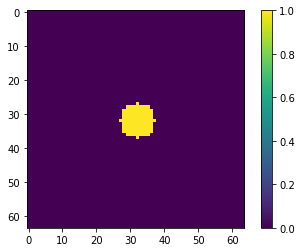

In [6]:
# Crear imagen a sacar DFT de 64x 64
mask2 = fun_mask(64, 5, 1, 'circ')

Figarse en los tiempos de cada uno

In [7]:
np.fft.fftn(mask2);

In [8]:
# Tiempo aproximado 1 min 40 s
fun_DFT(mask2, np.array([1,1]));

In [9]:
# Tiempo aproximado 1 min 30 s
fun_DFT2(mask2, np.array([1,1]));

In [10]:
# TIempo aproximado 2 s
fun_DFT_poderosa(mask2, np.array([1,1]));

# Punto 1

Implemente numéricamente, en Python o MATLAB, los métodos de difracción escalar de Transformadad de Fresnel y Espectro Angular en sus formas de sumatorias discretas (DFT), y en la forma basada en transformadas rápidas de Fourier (FFT). Compare el desempeño de ambos métodos en términos del tiempo necesario para realizar el cómputo de un mismo experimento difractivo de su elección. ¿La mejora de desempe o coincide con sus expectativas?

## Implementación computacional de Difracción por Transformada de Fresnel

In [11]:
def Fresnel (campo, w_length, z, dx, dy, metodo = 0):
    '''
    Fresnel es una función que calcula la propagación por medio de la implementación computacional de transformada de Fresnel

    Variables de entrada
     - campo: campo: (np.ndarray) ; campo al que se le calculará DFT
     - w_length: (float) ; longitud de onda
     - z: (float) ; distancia de propagación
     - dx: (int) ; delta de discretización en x del espacio o largo del pixel
     - dy: (int) ; delta de discretización en y del espacio o alto del pixel
     - metodo: (int) ; Puede tomar los valores:
                        0 para calcular DFT por FFT (o iFFT) con la función de numpy np.fft.fftn (valor por defecto)
                        1 para calcular DFT con la función fun_DFT
                        2 para calcular DFT con la función fun_DFT2
                        3 para calcular DFT con la función fun_DFT_poderosa

    Variables de salida
     - prop: (np.ndarray) ; campo propagado a la distancia z por medio de transformada de Fresnel computacional

    '''
    # Vector de onda
    k_vect = 2*np.pi/w_length


    # Definir espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # Calcular  el espacio de discretización del campo de entrada
    dx_0 = (w_length * z)/(dx * N)
    dy_0 = (w_length * z)/(dy * M) 

    # # Definir fases esfericas
    # C1 = np.exp( (1j*k_vect/(2*z) ) * ( (X*dx_0)**2 + (Y*dy_0)**2) )
    # C2 = np.exp( (1j*k_vect*z) )* np.exp ( (1j*k_vect/(2*z))*( (X*dx)**2 + (Y*dy)**2) )

    # Definir fases esfericas
    C1 = np.exp( (1j*k_vect/(2*z) ) * ( (X*dx_0)**2 + (Y*dy_0)**2) )
    # se quita el factor de amplitud 1/z
    C2 = np.exp( 1j*k_vect*z) / (1j*w_length) * np.exp ( (1j*k_vect/(2*z))*( (X*dx)**2 + (Y*dy)**2) )

    # 2. Preparar U'
    U_p = campo * C1

    # 3. DFT// de U' para obtener U'' en una distancia de propagacion z
    U_2p = np.fft.fftshift(fun_metodo_DFT(U_p, np.array([dx,dy]), False, metodo) )

    # 4. Escalar U
    prop = U_2p * C2

    return prop

## Implementación computacional de Difracción por Espectro Angular

In [12]:
def EspectroAngular (campo, w_length, z, dx, dy, metodo = 0):
    '''
    EspectroAngular es una función que calcula la propagación por medio de la implementación computacional de Espectro Angular

    Variables de entrada
     - campo: campo: (np.ndarray) ; campo al que se le calculará DFT
     - w_length: (float) ; longitud de onda
     - z: (float) ; distancia de propagación
     - dx: (int) ; delta de discretización en x del espacio o largo del pixel
     - dy: (int) ; delta de discretización en y del espacio o alto del pixel
     - metodo: (int) ; Puede tomar los valores:
                        0 para calcular DFT por FFT (o iFFT) con la función de numpy np.fft.fftn (valor por defecto)
                        1 para calcular DFT con la función fun_DFT
                        2 para calcular DFT con la función fun_DFT2
                        3 para calcular DFT con la función fun_DFT_poderosa

    Variables de salida
     - Uprop: (np.ndarray) ; campo propagado a la distancia z por medio de Espectro Angular computacional

    '''
  # Vector de onda
    k_vect = 2*np.pi/w_length

    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(N/2), int(N/2), 1)
    y = np.arange(-int(M/2), int(M/2), 1)
    X,Y = np.meshgrid(x,y)

    # Calcular el tamaño de discretización del espacio de las frecuencias 
    fX =  (1 / (N*dx))
    fY =  (1 / (M*dy))

    # 2. Calculamos el espectro angular discreto A[p,q,0] utilizando FFT.
    A0 = np.fft.fftshift(fun_metodo_DFT(campo, np.array([dx,dy]), False, metodo))

    # definimos las fases esféricas 
    C1 = np.exp((1j*k_vect*z) * np.sqrt(1 - (w_length**2)*(  (X*fX)**2 + (Y*fY)**2) ) )

    # 3. Aplicamos la función de transferencia 
    Az = A0 * C1

    # 4. Calculamos el campo propagado U[n,m,z] como la IFFT del espectro angular propagado y reordenamos
    Uprop = fun_metodo_DFT(Az, np.array([dx,dy]), True, metodo)


    return Uprop

## Prueba de Transformada de Fresnel usando una abertura circular y comparación FFT con DFT en imagen 128x128

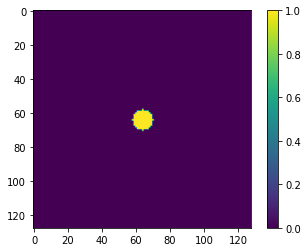

0.0001969230769230769

In [13]:
# Creación de Abertura circular
mask = fun_mask(128, 6, 1, 'circ')
# Calcular z critico
fun_z_c(np.shape(mask)[0], dx, w_length)

### Fresnel, FFT

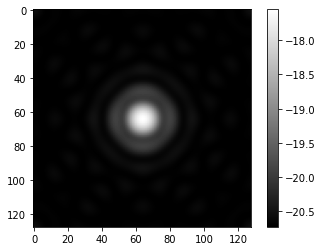

(128, 128)

In [14]:
# Propagación por Transformada de Fresnel por FFT
propFresnelC = Fresnel(mask, w_length, 400*um, dx, dx, 0 )
fun_ploteo_complejo(propFresnelC, "I", 0)
np.shape(propFresnelC)

### Fresnel, DFT

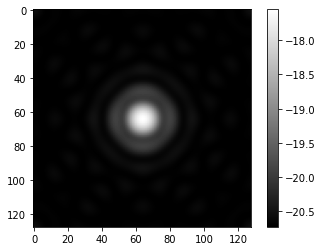

(128, 128)

In [15]:
# Propagación por Transformada de Fresnel por DFT con la función fun_DFT_poderosa
# Nota 1: para el tamaño 128x128 en el computador de los desarrolladores tarda aprox 40 segundos
# Nota 2: puede intentar las otras funciones de DFT pero se advierte su lentitud
propFresnelC = Fresnel(mask, w_length, 400*um, dx, dy, 3 )
fun_ploteo_complejo(propFresnelC, "I", 0)
np.shape(propFresnelC)

## Prueba de Espectro Angular usando una abertura circular y comparación FFT con DFT en imagen 128x128

### FFT

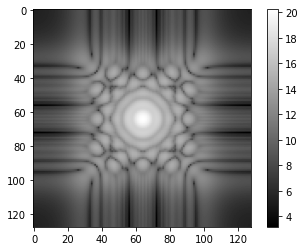

In [16]:
# Propagación por Espectro Angular por FFT
propASC_FFT = EspectroAngular(mask, w_length, 100*um, dx, dy, 0)
fun_ploteo_complejo(propASC_FFT, "I", 0)

### DFT

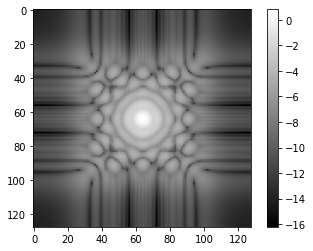

In [17]:
# Propagación por Transformada de Fresnel por DFT con la función fun_DFT_poderosa
# Nota 1: para el tamaño 128x128 en el computador de los desarrolladores tarda aprox 55 segundos
# Nota 2: puede intentar las otras funciones de DFT pero se advierte su lentitud
propASC = EspectroAngular(mask, w_length, 100*um, dx, dy, 3)
fun_ploteo_complejo(propASC, "I", 0)

Una vez comparado los algoritmos de DFT y FFT, se prosigue únicamente con FFT

## Prueba de Transformada de Fresnel usando un obstáculo circular de 1024x1024

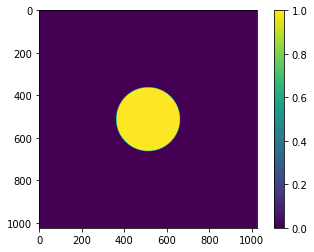

0.0015753846153846152

In [18]:
# Creación de Abertura circular
mask = fun_mask(1024, 150, 1, 'circ')
# Calcular z critico
fun_z_c(np.shape(mask)[0], dx, w_length)

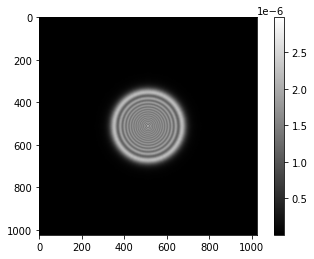

In [19]:
# Propagación por Transformada de Fresnel por FFT
propFresnelC = Fresnel(mask, w_length, 2*mm, dx, dx, 0 )
fun_ploteo_complejo(propFresnelC, "I", 1)

## Prueba de Espectro Angular usando un obstáculo circular de 1024x1024

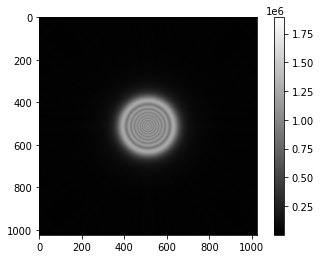

(128, 128)

In [20]:
# Propagación por Espectro Angular por FFT
propASC_FFT = EspectroAngular(mask, w_length, 2*mm, dx, dy, 0)
fun_ploteo_complejo(propASC_FFT, "A", 1)
np.shape(propASC)

## Prueba de Transformada de Fresnel usando un obstáculo rectangular de 1024x1024

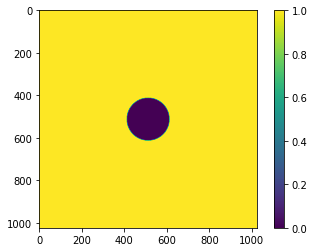

0.0015753846153846152

In [21]:
# Creación de obstáculo circular
mask2 = fun_mask(1024, 100, 0)
# Calcular z critico
fun_z_c(1024,dx,w_length)

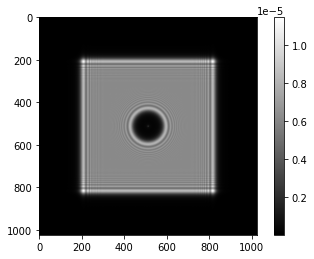

In [22]:
# Propagación por Transformada de Fresnel por FFT
propFresnelC = Fresnel(mask2, w_length, 1*mm, dx, dy, 0 )
fun_ploteo_complejo(propFresnelC, "I", 1)

## Prueba de Espectro Angular usando un obstáculo circular de 1024x1024

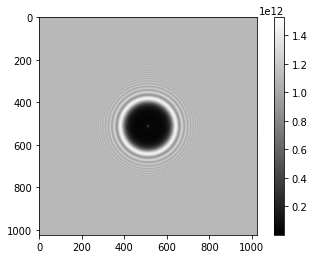

(1024, 1024)

In [23]:
# Propagación por Espectro Angular por FFT
propASC = EspectroAngular(mask2, w_length, 2*mm, dx, dy, 0)
fun_ploteo_complejo(propASC, "I", 1)
np.shape(propASC)

## Prueba de Transformada de Fresnel usando una abertura rectangular de 512x12

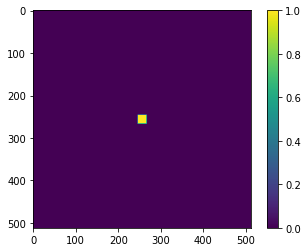

0.0007876923076923076

In [24]:
# Crear una apertura rectangular
mask3 = fun_mask(512,20, 1, 'rect')
fun_z_c(512, dx, w_length)

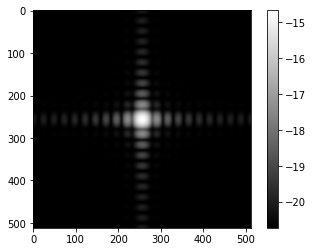

In [25]:
# Propagación por Transformada de Fresnel
propFresnelR = Fresnel(mask3, w_length, 800*um, dx, dy)
fun_ploteo_complejo(propFresnelR, "I",0)

## Prueba de Espectro Angular usando una abertura rectangular de 512x512

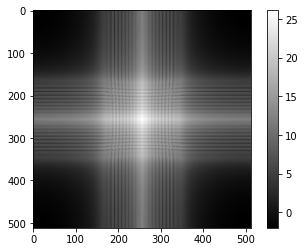

In [26]:
# Propagación por Espectro Angular
propASR = EspectroAngular(mask3, w_length, 240*um, dx, dy)
fun_ploteo_complejo(propASR, "I", 0)

# **Punto 2**

## **Punto 2 a**

In [27]:
def fun_transmitance_a(campo, dx,dy, m, L):
    #dimensiones del campo
    N_x, N_y= np.shape(campo)

    # Discretizacion del campo
    n = np.arange(0,N_x,1)

    # función de transmitancia
    transmitancia = 1/2*(1+m*np.cos(2*np.pi*n/L))

    # matriz de unos
    matriz_ones = np.ones((N_x,N_y), dtype = np.complex128)

    # broadcasting para tener la transmitancia independiente de y
    matriz_transmitancia = transmitancia*matriz_ones

    return matriz_transmitancia

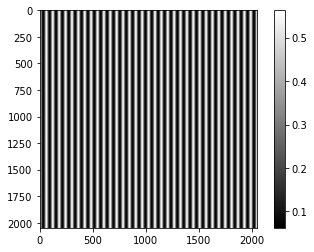

zcritico  0.0031507692307692304


In [28]:
# Creación de la transmitancia
m = 0.5
L= 60      # 60 micras
n = 1
transmitancia_a=fun_transmitance_a(np.ones((2048,2048)),1,1,m, L)
fun_ploteo_complejo( transmitancia_a, "I", 1)
print("zcritico ", fun_z_c(transmitancia_a.shape[0], dx, w_length))

### N pares

In [29]:
# Calcular los diferentes valores de z
for i in np.arange(2,10,2):
    z_a = i*(L*dx)**2/w_length
    print("z calculado: ", z_a, "con n= ",i)
    
# Guardarlos en un arreglo
z_a = 1*(L*dx)**2/w_length
z_prop = np.linspace(2*z_a, 8*z_a, 4)
z_prop

z calculado:  0.011076923076923074 con n=  2
z calculado:  0.02215384615384615 con n=  4
z calculado:  0.03323076923076922 con n=  6
z calculado:  0.0443076923076923 con n=  8


array([0.01107692, 0.02215385, 0.03323077, 0.04430769])

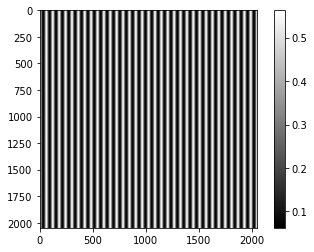

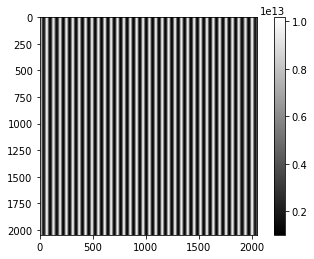

0.011076923076923074


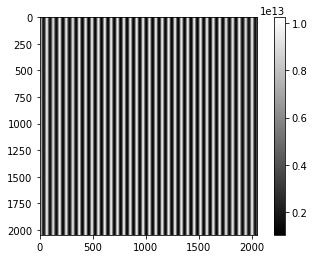

0.02215384615384615


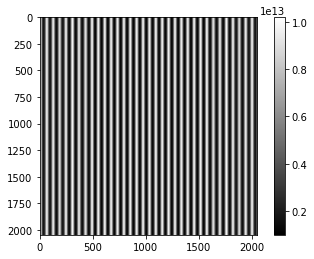

0.03323076923076922


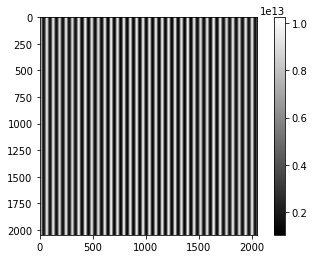

0.0443076923076923


In [30]:
# Graficar los valores de la transmitancia propagada
# La primera gráfica es la transmitancia en z =0
fun_ploteo_complejo( transmitancia_a, "I", 1)
for i in z_prop:    
    fun_ploteo_complejo(EspectroAngular(transmitancia_a, w_length, i, dx, dy), "I", 1)
    print(i)

### N impares

In [31]:
# Calcular los diferentes valores de z
for i in np.arange(1,9,2):
    z_a = i*(L*dx)**2/w_length
    print("z calculado: ", z_a, "con n= ",i)
    
# Guardarlos en un arreglo
z_a = 1*(L*dx)**2/w_length
z_prop = np.linspace(1*z_a, 7*z_a, 4)
z_prop

z calculado:  0.005538461538461537 con n=  1
z calculado:  0.01661538461538461 con n=  3
z calculado:  0.02769230769230769 con n=  5
z calculado:  0.038769230769230764 con n=  7


array([0.00553846, 0.01661538, 0.02769231, 0.03876923])

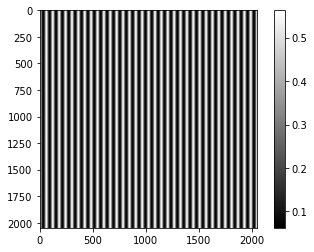

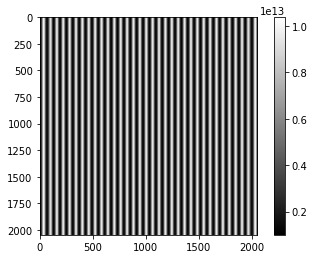

0.005538461538461537


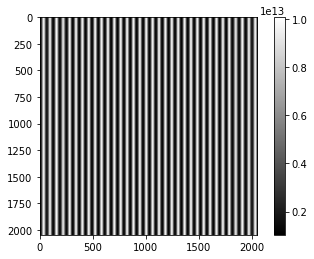

0.016615384615384615


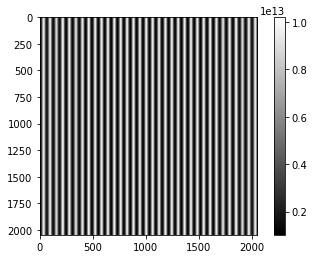

0.02769230769230769


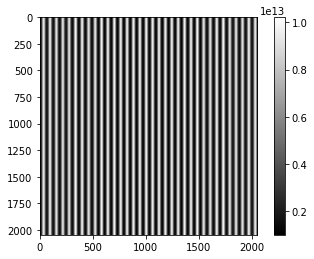

0.038769230769230764


In [32]:
# Graficar los valores de la transmitancia propagada
# la primera gráfica es la transmitancia en z=0
fun_ploteo_complejo( transmitancia_a, "I", 1)
for i in z_prop:    
    fun_ploteo_complejo(EspectroAngular(transmitancia_a, w_length, i, dx, dy), "I", 1)
    print(i)

## Otros Planos

### Entre 1 y 2

In [33]:
# Calcular los diferentes valores de z
for i in np.arange(1,2,0.1):
    z_a = i*(L*dx)**2/w_length
    print("z calculado: ", z_a, "con n= ",i)
    
# Guardarlos en un arreglo
z_a = 1*(L*dx)**2/w_length
z_prop = np.linspace(1*z_a, 2*z_a, 11)
z_prop

z calculado:  0.005538461538461537 con n=  1.0
z calculado:  0.006092307692307691 con n=  1.1
z calculado:  0.006646153846153846 con n=  1.2000000000000002
z calculado:  0.007200000000000001 con n=  1.3000000000000003
z calculado:  0.007753846153846155 con n=  1.4000000000000004
z calculado:  0.00830769230769231 con n=  1.5000000000000004
z calculado:  0.008861538461538464 con n=  1.6000000000000005
z calculado:  0.009415384615384617 con n=  1.7000000000000006
z calculado:  0.009969230769230772 con n=  1.8000000000000007
z calculado:  0.010523076923076927 con n=  1.9000000000000008


array([0.00553846, 0.00609231, 0.00664615, 0.0072    , 0.00775385,
       0.00830769, 0.00886154, 0.00941538, 0.00996923, 0.01052308,
       0.01107692])

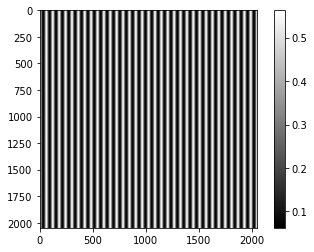

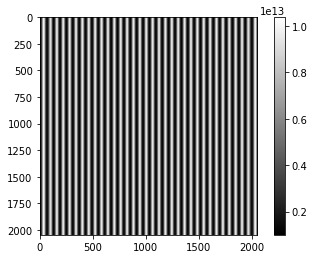

0.005538461538461537


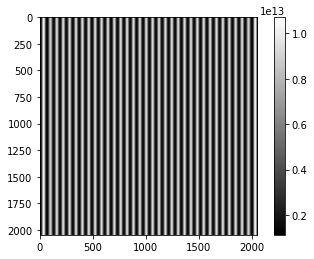

0.006092307692307691


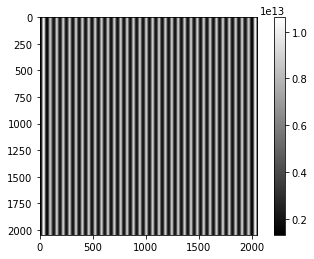

0.006646153846153845


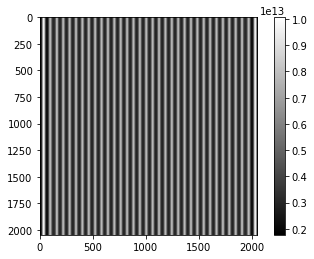

0.007199999999999998


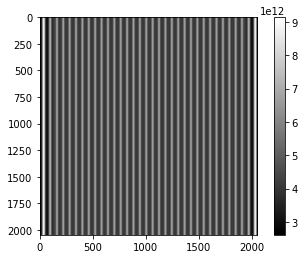

0.007753846153846152


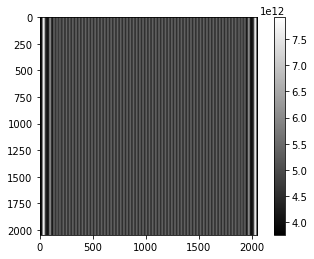

0.008307692307692306


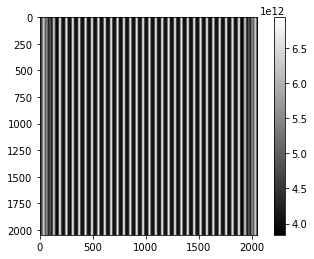

0.008861538461538459


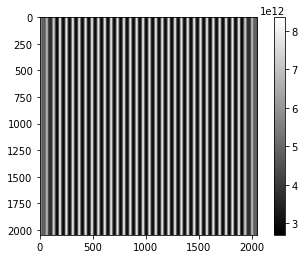

0.009415384615384614


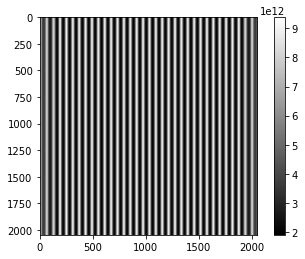

0.009969230769230767


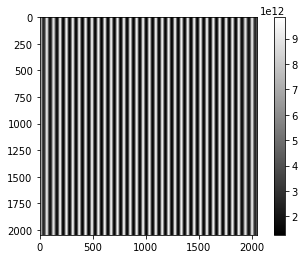

0.01052307692307692


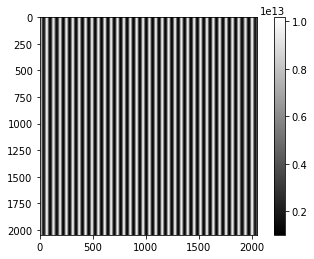

0.011076923076923074


In [34]:
# Graficar los valores de la transmitancia propagada
# la primera gráfica es la transmitancia en z=0
fun_ploteo_complejo( transmitancia_a, "I", 1)
for i in z_prop:    
    fun_ploteo_complejo(EspectroAngular(transmitancia_a, w_length, i, dx, dy), "I", 1)
    print(i)

### Entre 2 y 3


In [35]:
# Calcular los diferentes valores de z
for i in np.arange(2,3,0.1):
    z_a = i*(L*dx)**2/w_length
    print("z calculado: ", z_a, "con n= ",i)
    
# Guardarlos en un arreglo
z_a = 1*(L*dx)**2/w_length
z_prop = np.linspace(2*z_a, 3*z_a, 11)
z_prop

z calculado:  0.011076923076923074 con n=  2.0
z calculado:  0.01163076923076923 con n=  2.1
z calculado:  0.012184615384615382 con n=  2.2
z calculado:  0.012738461538461539 con n=  2.3000000000000003
z calculado:  0.013292307692307692 con n=  2.4000000000000004
z calculado:  0.013846153846153848 con n=  2.5000000000000004
z calculado:  0.014400000000000001 con n=  2.6000000000000005
z calculado:  0.014953846153846154 con n=  2.7000000000000006
z calculado:  0.01550769230769231 con n=  2.8000000000000007
z calculado:  0.016061538461538464 con n=  2.900000000000001


array([0.01107692, 0.01163077, 0.01218462, 0.01273846, 0.01329231,
       0.01384615, 0.0144    , 0.01495385, 0.01550769, 0.01606154,
       0.01661538])

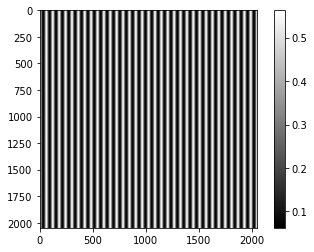

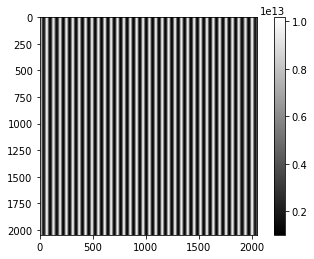

0.011076923076923074


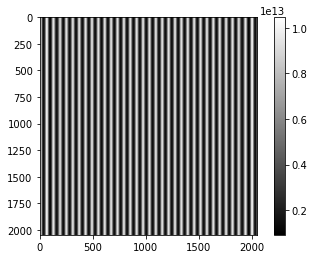

0.011630769230769228


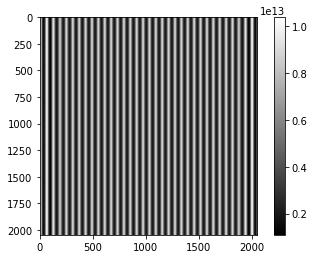

0.012184615384615382


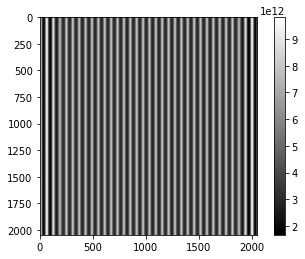

0.012738461538461535


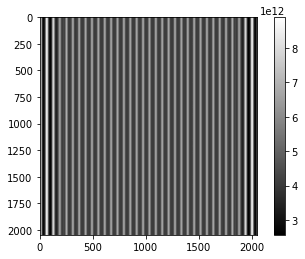

0.01329230769230769


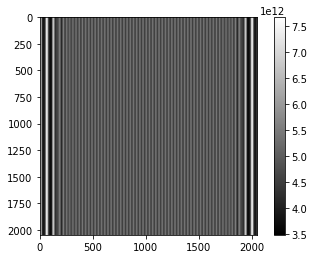

0.013846153846153843


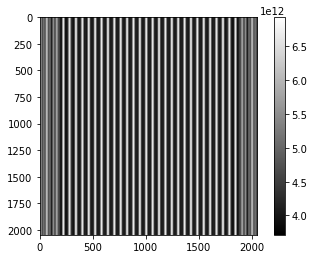

0.014399999999999996


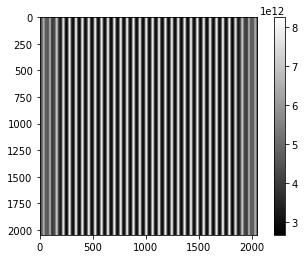

0.014953846153846151


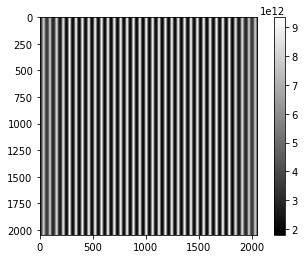

0.015507692307692304


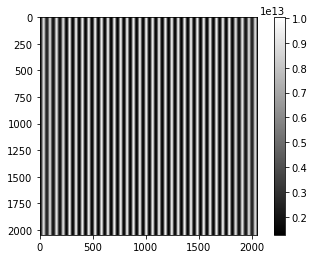

0.016061538461538457


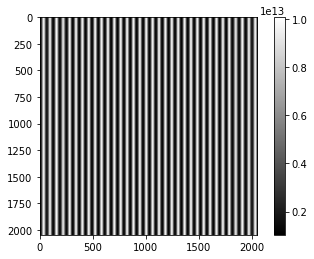

0.01661538461538461


In [36]:
# Graficar los valores de la transmitancia propagada
# la primera gráfica es la transmitancia en z=0
fun_ploteo_complejo( transmitancia_a, "I", 1)
for i in z_prop:    
    fun_ploteo_complejo(EspectroAngular(transmitancia_a, w_length, i, dx, dy), "I", 1)
    print(i)

## **Punto 2b** Principio de Babinet

In [37]:
def opening(dx, dy, radio):
 # Esta es otra función de creación de máscaras 
  N,M = (1024,1024)
  x = np.arange(-int(M/2), int(M/2), 1)
  y = np.arange(-int(N/2), int(N/2), 1)
  
  fx = x * dx
  fy = y * dy
  
  X,Y = np.meshgrid(fx, fy)
  circulo = np.array(X**2 + Y**2 <= radio**2, dtype = bool)
  plt.imshow(circulo)
  plt.colorbar()
  plt.show()

  return circulo

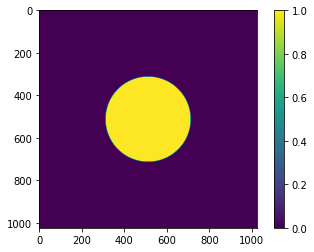

In [38]:
# transmitancia, apertura circular, con la cual se 
# demostrará principio de Babinet
apertura = opening(dx, dy, 200*um)

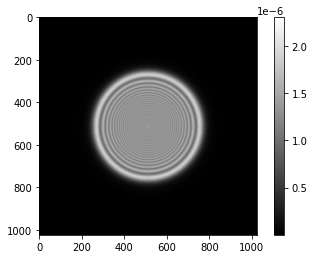

In [39]:
# Propagar en el espacio libre con Fresnel
espaciolibre = Fresnel(apertura, w_length, 2.16*mm, dx, dy, 0)
fun_ploteo_complejo(espaciolibre, "I", 1)

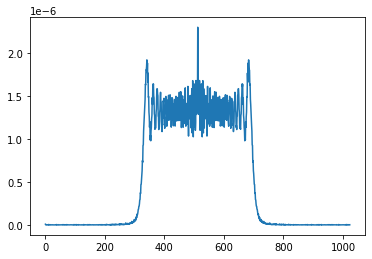

In [40]:
# Graficar las magnitudes de la diagonal de la imagen anterior 
plt.plot(np.abs(np.diag(np.abs(espaciolibre)**2)))



In [41]:
def sumadona(dx, dy, radiominimo, radiomaximo):
  # Funcion para crear una mascara de dona
  N,M = (1024,1024)
  x = np.arange(-int(M/2), int(M/2), 1)
  y = np.arange(-int(N/2), int(N/2), 1)
  
  fx = x * dx
  fy = y * dy
  
  X,Y = np.meshgrid(fx, fy)
  dona1 = np.array((X**2 + Y**2 <= radiomaximo**2), dtype= bool) 
  dona2 = np.array((X**2 + Y**2 >= radiominimo**2), dtype = bool)
  dona = dona1 * dona2
  plt.imshow(dona)
  plt.colorbar()
  plt.show()

  return dona

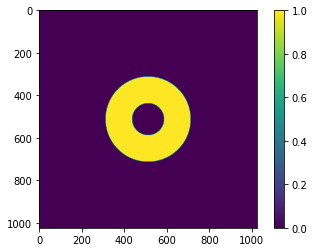

In [42]:
# transmitancia de dona
tA = sumadona(dx, dy, 75*um, 200*um)

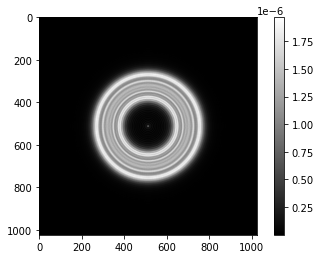

In [43]:
# Propagar la transmitancia (dona) por T. de Fresnel
tAFresnel = Fresnel(tA, w_length, 2.16*mm, dx, dy, 0)
fun_ploteo_complejo(tAFresnel, "I", 1)

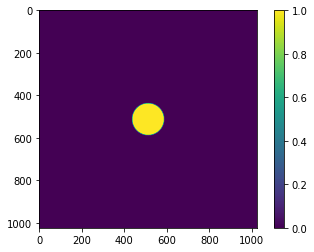

In [44]:
# transmitancia de una apertura circular
tAcom = opening(dx,dy,75*um)

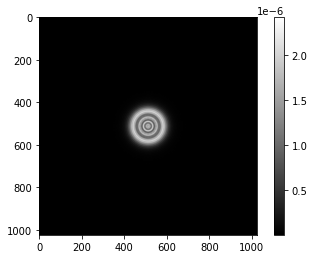

In [45]:
# Propagar la transmitancia (apertura) circular
tAcomFresnel = Fresnel(tAcom, w_length, 2.16*mm, dx, dy, 0)
fun_ploteo_complejo(tAcomFresnel, "I", 1)

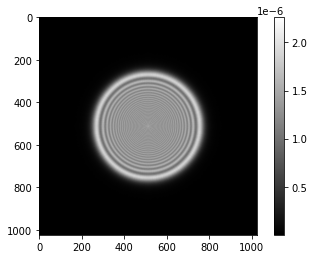

In [46]:
# Superposicion de la propagacion de las transmitancias
Babinet = tAFresnel + tAcomFresnel
fun_ploteo_complejo(Babinet, "I", 1)

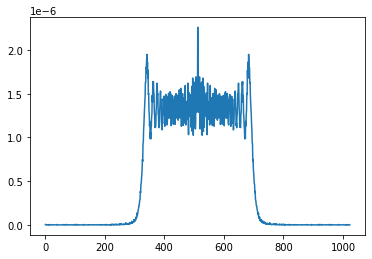

In [47]:
# Grafica de las magnitudes de las transmitancias superpuestas en 
# el espacio
plt.plot(np.abs(np.diag(np.abs(Babinet)**2)))

# **Punto 2c** Punto de Poisson

In [48]:
def sumadona(dx, dy, radiominimo, radiomaximo):
  # Funcion para máscara de una dona
  N,M = (1024,1024)
  x = np.arange(-int(M/2), int(M/2), 1)
  y = np.arange(-int(N/2), int(N/2), 1)
  
  fx = x * dx
  fy = y * dy
  
  X,Y = np.meshgrid(fx, fy)
  dona1 = np.array((X**2 + Y**2 <= radiomaximo**2), dtype= bool) 
  dona2 = np.array((X**2 + Y**2 >= radiominimo**2), dtype = bool)
  dona = dona2 * dona1
  plt.imshow(dona)
  plt.colorbar()
  plt.show()

  return dona

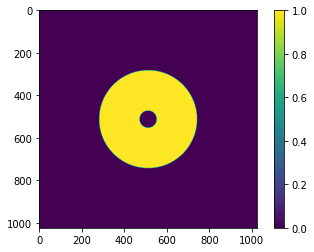

In [49]:
# Crear transmitancia de dona (apertura)
Obstaculolimitado = sumadona(dx, dy, 40*um, 230*um)

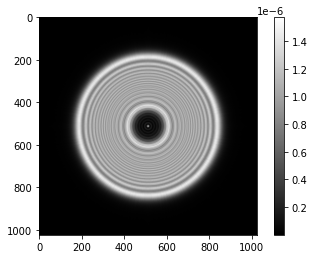

[[-2.27751493e-05+2.67498732e-05j -1.77686854e-05-2.39601114e-06j
   3.05232330e-06+1.83191496e-05j ... -2.55283420e-05+3.51933269e-05j
   3.05232330e-06+1.83191496e-05j -1.77686854e-05-2.39601114e-06j]
 [-1.77686854e-05-2.39601114e-06j -9.27930526e-06-7.01869730e-06j
  -1.60184751e-05-3.88134091e-06j ... -1.84534178e-05-1.33396675e-05j
  -1.60184751e-05-3.88134091e-06j -9.27930526e-06-7.01869730e-06j]
 [ 3.05232330e-06+1.83191496e-05j -1.60184751e-05-3.88134091e-06j
   1.92048577e-05-2.38523395e-05j ...  2.66378092e-05+1.66007451e-05j
   1.92048577e-05-2.38523395e-05j -1.60184751e-05-3.88134091e-06j]
 ...
 [-2.55283420e-05+3.51933269e-05j -1.84534178e-05-1.33396675e-05j
   2.66378092e-05+1.66007451e-05j ... -2.28637871e-05+3.74927903e-05j
   2.66378092e-05+1.66007451e-05j -1.84534178e-05-1.33396675e-05j]
 [ 3.05232330e-06+1.83191496e-05j -1.60184751e-05-3.88134091e-06j
   1.92048577e-05-2.38523395e-05j ...  2.66378092e-05+1.66007451e-05j
   1.92048577e-05-2.38523395e-05j -1.60184751e-

In [50]:
# Propagar con Fresnel la transmitancia obteniendo el punto de Arago
Arago = Fresnel(Obstaculolimitado, w_length, 2.46*mm, dx, dy, 0)
fun_ploteo_complejo(Arago, "I", 1)
print(Arago)

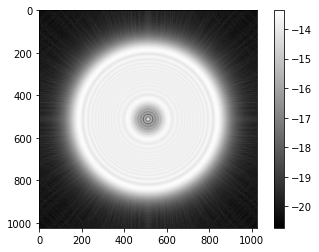

In [51]:
# Amplificarlo con logaritmo
Arago = Fresnel(Obstaculolimitado, w_length, 2.46*mm, dx, dy, 0)
fun_ploteo_complejo(Arago, "I", 0)

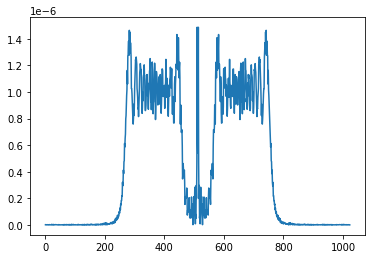

In [52]:
# Graficar las magnitudes de la diagonal del punto de Poisson
plt.plot(np.abs(np.diag(np.abs(Arago)**2)))
# Notar en el centro el pico de intensidad, que representa el punto de Poisson